In [179]:
import os, boto3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def download_file_from_s3(bucket_name, s3_file_path, local_file_path):
    try:        
        s3_client = boto3.client(
            's3',
            aws_access_key_id = os.getenv('AWS_SECRET_ACCESS_KEY'),
            aws_secret_access_key = os.getenv('AWS_ACCESS_KEY_ID'),
            region_name = os.getenv('REGION')
        )

        s3_client.download_file(bucket_name, s3_file_path, local_file_path)
        print(f"File downloaded successfully to {local_file_path}")
        
    except Exception as e:
        print(f"Error downloading file: {str(e)}")

download_file_from_s3(
    "animal-center", 
    "curated/austin-animal-center-curated.csv", 
    "../data/animal-center-anlaysis.csv"
)

animal_df = pd.read_csv("../data/animal-center-anlaysis.csv", header=0, skiprows=0)

File downloaded successfully to ../data/animal-center-anlaysis.csv


# **Austin Animal Center**

- Monthly animal intake trends
- Distribution of intake types and conditions.
- Breakdown of intake data by breed or location.

In [41]:
animal_df['datetime'] = pd.to_datetime(animal_df['datetime'])

### Distribution of intake types and conditions.

In [108]:
animal_type_df = animal_df[["animal_id", "intake_type", "intake_condition"]] \
.groupby(["intake_type", "intake_condition"]) \
.count() \
.rename(columns = {"animal_id": "Number of animals"})

In [162]:
intake_type = []
intake_condition = []

for animal_type in list(animal_type_df.index):
    intake_type.append(animal_type[0])
    intake_condition.append(animal_type[1])

animal_type_condition_dist_df = pd.DataFrame(
    {
        "intake_type": intake_type,
        "intake_condition": intake_condition,
        "number_animal": list(animal_type_df[['Number of animals']].values.ravel())
    }
)

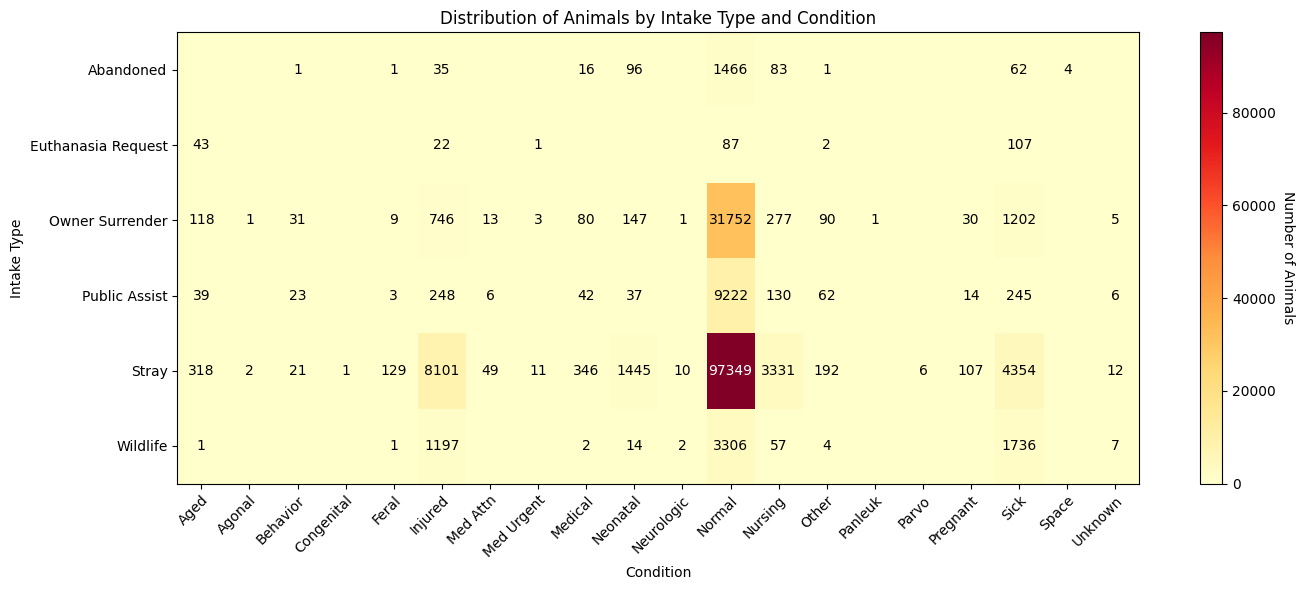

In [183]:
pivot_table = animal_type_condition_dist_df.pivot(
    index='intake_type', 
    columns='intake_condition', 
    values='number_animal'
).fillna(0)

fig, ax = plt.subplots(figsize=(14, 6))

im = ax.imshow(pivot_table, aspect='auto', cmap='YlOrRd')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of Animals', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns)
ax.set_yticklabels(pivot_table.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for condition in range(len(pivot_table.index)):
    for intake_type in range(len(pivot_table.columns)):
        value = pivot_table.iloc[condition, intake_type]
        if value > 0:  
            text_color = 'white' if value > pivot_table.values.max() / 2 else 'black'
            ax.text(intake_type, condition, f'{int(value)}', 
                   ha="center", va="center", 
                   color=text_color)

ax.set_title('Distribution of Animals by Intake Type and Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Intake Type')

plt.tight_layout()
plt.show()

### Monthly animal intake trends

In [194]:
animal_df.groupby("datetime")[['name']].count().sample(10)

,name
datetime,
2017-01-09 12:49:00+00:00,1
2017-05-29 11:47:00+00:00,1
2022-01-27 16:25:00+00:00,1
2018-04-21 10:06:00+00:00,1
2017-10-03 11:48:00+00:00,1
2022-09-06 11:51:00+00:00,2
2018-04-25 11:29:00+00:00,2
2018-05-25 10:56:00+00:00,4
2019-07-03 13:19:00+00:00,1


ValueError: cannot convert float NaN to integer

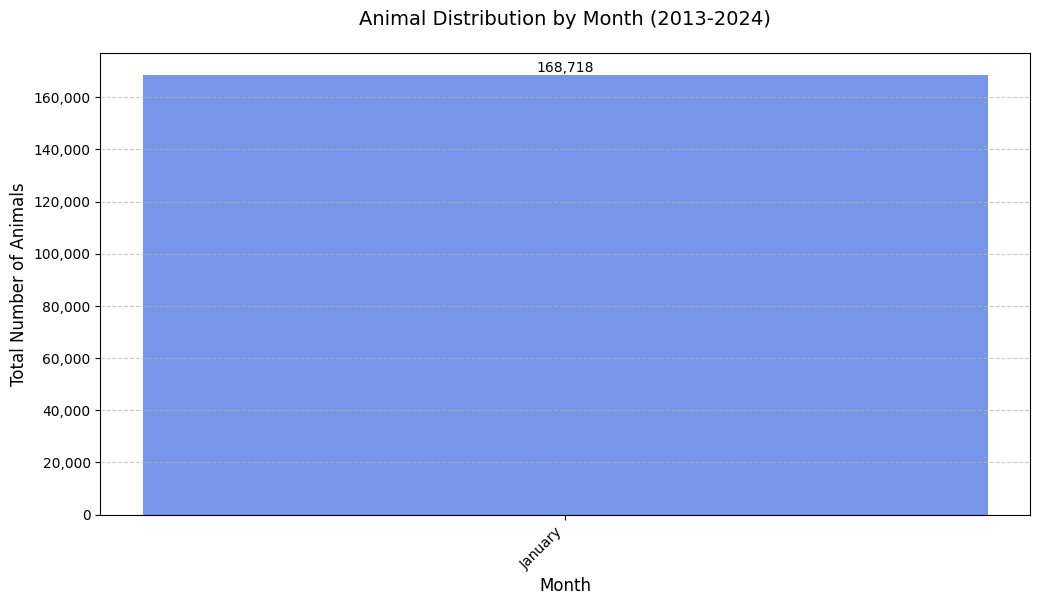

In [193]:
animal_df.index = pd.to_datetime(animal_df.index)
monthly_pattern = animal_df.groupby(animal_df.index.strftime('%B'))['name'].count()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_pattern = monthly_pattern.reindex(month_order)
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(
    month_order,
    monthly_pattern.values,
    color='royalblue',
    alpha=0.7
)

ax.set_title('Animal Distribution by Month (2013-2024)', pad=20, fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Number of Animals', fontsize=12)

plt.xticks(rotation=45, ha='right')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom')

average = monthly_pattern.mean()
ax.axhline(y=average, color='red', linestyle='--', alpha=0.5, 
           label=f'Average: {average:,.0f} animals/month')

ax.legend()
plt.tight_layout()
plt.show()

print("\nMonthly Statistics:")
print(f"Average animals per month: {monthly_pattern.mean():,.2f}")
print(f"Maximum animals in a month: {monthly_pattern.max():,.0f} ({monthly_pattern.idxmax()})")
print(f"Minimum animals in a month: {monthly_pattern.min():,.0f} ({monthly_pattern.idxmin()})")
print("\nMonthly Distribution:")

for month in month_order:
    print(f"{month}: {monthly_pattern[month]:,}")